# Optimization

## Import libraries

In [29]:
# Default libraries
import numpy as np
import scipy.optimize as optimize
import matplotlib.pyplot as plt

# Custom libraries
import Functions.data_tools as data_tools
from Functions.temple_data import TempleData
from Functions.artifact_removal_tool import ART
from Functions import eeg_quality_index as eqi
from Functions import optimization as optimization


# Magic command to automatically reload modules
%load_ext autoreload
%autoreload 2 

## Import data

In [30]:
file = r"Data\Temple\edf\01_tcp_ar\072\00007229\s001_2010_11_02\00007229_s001_t000.edf"
# file = r"Data\Temple\edf\01_tcp_ar\002\00000254\s005_2010_11_15\00000254_s005_t000.edf" # NO artifacts
# file = r"Data\Temple\edf\01_tcp_ar\002\00000254\s005_2010_11_15\00000254_s005_t000.edf" # With artifacts
temple = TempleData(file)

Extracting EDF parameters from c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Data\Temple\edf\01_tcp_ar\072\00007229\s001_2010_11_02\00007229_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


## Get artifacts and clean data

In [31]:
# Settings
artifact_type = "eyem"
window_length = 3

# Get artifacts
artifacts_file = fr"Data\\Temple\\csv\\labels_{temple.montage_type}.csv"
temple.get_artifacts_from_csv(artifacts_file)
[artifacts_chans, artifacts_data] = temple.get_artifact_type_data(
    artifact_type = artifact_type,
    window_length = window_length,
    )

# Get clean data
clean = temple.get_clean_data(window_length)
# clean_avg = np.mean(clean, axis=0) * clean.shape[0]
clean_avg = clean[10,:,:]

## Single run example

In [32]:
# Settings
# - Temple data
artifact_type = "eyem"  # Type of artifact to process
test_percentage = 20    # Percentage of artifact to use as test [\%]
split_seed = 42         # Seed for reproducibility
window_length = 3       # Length of window data [sec]

window_samples = int(window_length * temple.srate)

# - Optimization
x0 = (5, 1, 0.018)
n_clusters = slice(1, 6, 1)
fd_threshold = slice(1, 3, 0.2)
ssa_threshold = slice(0.005, 0.02, 0.005)

# Get artifacts
artifacts_file = fr"Data\\Temple\\csv\\labels_{temple.montage_type}.csv"
temple.get_artifacts_from_csv(artifacts_file)
[artifacts_chans, artifacts_data] = temple.get_artifact_type_data(
    artifact_type = artifact_type,
    window_length = window_length,
    )

# Get clean data
clean = temple.get_clean_data(window_length)
# clean_avg = np.mean(clean, axis=0) * clean.shape[0]
clean_avg = clean[10,:,:]

# Separate optimization and test sets
[i_optim, i_test] = data_tools.split_list(
    lst = list(artifacts_chans),
    test_percentage = test_percentage,
    seed = split_seed
    )

# Creat artifact removal
art = ART(
    window_length = window_length,  
    n_clusters = x0[0],
    fd_threshold = x0[1],
    ssa_threshold = x0[2] 
)

# Create EEG Quality index
eqi_total = np.zeros(artifacts_data.shape[:2])

# for (a, artifact) in enumerate(artifacts_chans):
#     for (c, chan) in enumerate(artifact):
#         subset_chans = [temple.ch_names.index(chan) for chan in artifact if chan in temple.ch_names]
#         test_eeg = art.remove_artifacts(
#             eyem_artifacts[a,c,:],
#             srate = temple.srate
#             )
    
#         eqi_total[a,:] = eqi.scoring(
#             clean_eeg = clean_avg[subset_chans,:],
#             test_eeg = test_eeg,
#             srate_clean = temple.srate,
#             srate_test = temple.srate,
#             window = int(window_samples // 10),
#             slide = int(window_samples // 20)
#         )[0]  

for (a, artifact) in enumerate(artifacts_chans):
    print(f"Artifact {a}")
    subset_chans = [temple.ch_names.index(chan) for chan in artifact if chan in temple.ch_names]
    test_eeg = art.remove_artifacts(
        artifacts_data[a,:,:],
        srate = temple.srate
        )

    eqi_total[a,:] = eqi.scoring(
        clean_eeg = clean_avg[subset_chans,:],
        test_eeg = test_eeg,
        srate_clean = temple.srate,
        srate_test = temple.srate,
        window = int(window_samples // 10),
        slide = int(window_samples // 20)
    )[0]  

    a = 0

Artifact 0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
Artifact 1
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\artifact_removal_tool.py:170: UserWarning: Null variance found, returning raw EEG
  warnings.warn("Null variance found, returning raw EEG")
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mea

In [33]:
eqi_total

array([[ 0.        ,  5.26315789,  0.        , 47.36842105],
       [ 0.        ,  0.        ,  0.        , 73.68421053]])

IndexError: index 2 is out of bounds for axis 0 with size 2

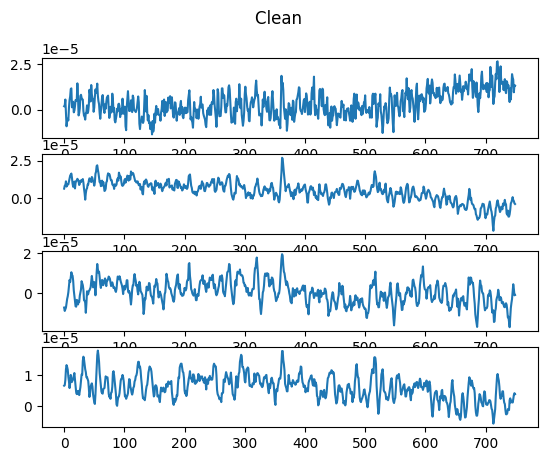

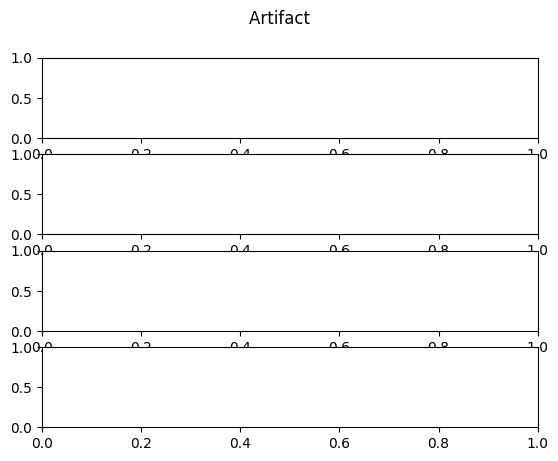

In [34]:
fig, ax = plt.subplots(len(subset_chans))
fig.suptitle("Clean ")
for c,chan in enumerate(subset_chans):
    ax[c].plot(clean_avg[c,:])

fig, ax = plt.subplots(len(subset_chans))
fig.suptitle("Artifact ")
for c,chan in enumerate(subset_chans):
    ax[c].plot(artifacts_data[2,c,:])

    

## Optimization example

In [ ]:
# Settings
# - Temple data
artifact_type = "eyem"  # Type of artifact to process
test_percentage = 20    # Percentage of artifact to use as test [\%]
split_seed = 42         # Seed for reproducibility
window_length = 5       # Length of window data [sec]

window_samples = int(window_length * temple.srate)

# - Optimization parameters
n_clusters = (1, 10)
fd_threshold = (0.1, 5)
ssa_threshold = (0.001, 0.1)

# n_clusters = slice(1, 6, 1)
# fd_threshold = slice(1, 3, 0.2)
# ssa_threshold = slice(0.005, 0.02, 0.005)

# Get artifacts
artifacts_file = fr"Data\\Temple\\csv\\labels_{temple.montage_type}.csv"
temple.get_artifacts_from_csv(artifacts_file)
[artifacts_chans, artifacts_data] = temple.get_artifact_type_data(
    artifact_type = artifact_type,
    window_length = window_length,
    )

# Get clean data
clean = temple.get_clean_data(window_length)
clean_avg = clean[10,:,:]
# clean_avg = np.mean(clean, axis=0) * clean.shape[0]

# Optimize ART parameters
for a,artifact in enumerate(artifacts_chans):
    # Get subset of channels based on artifact
    subset_chans = [temple.ch_names.index(chan) for chan in artifact if chan in temple.ch_names]

    x0 = (5, 1, 0.018)
    bounds = (n_clusters, fd_threshold, ssa_threshold)
    args = (
        clean_avg[subset_chans,:],
        artifacts_data[a,:,:], 
        temple.srate,
        window_length
        )
    res = optimize.minimize(
        optimization.maximize_eqi,
        x0 = x0,
        bounds = bounds,
        args = args,
        method = "CG",
        callback = lambda:print("Running"),
        tol = 1e-20,
        options = {
            "maxiter": 100
        }
    )

In [ ]:
res

## Brute force optimization

Test different starting points and check the fun value

In [ ]:
np.arange(0.005, 0.5, 0.1).shape

In [ ]:
for a,artifact in enumerate(artifacts_chans):
    # Get subset of channels based on artifact
    subset_chans = [temple.ch_names.index(chan) for chan in artifact if chan in temple.ch_names]

    n_clusters = slice(1, 10, 1)
    fd_threshold = slice(0.1, 5, 1)
    ssa_threshold = slice(0.005, 0.5, 0.01)
    ranges = (n_clusters, fd_threshold, ssa_threshold)
    
    args = (
        clean_avg[subset_chans,:],
        artifacts_data[a,:,:], 
        temple.srate,
        window_length
        )
    
    res_brute = optimize.brute(
        optimization.maximize_eqi,
        ranges = ranges,
        args = args
    )
    

## Differential evolution optimization

In [ ]:
for a,artifact in enumerate(artifacts_chans):
    # Get subset of channels based on artifact
    subset_chans = [temple.ch_names.index(chan) for chan in artifact if chan in temple.ch_names]

    n_clusters = (1, 10)
    fd_threshold = (0.1, 10)
    ssa_threshold = (0.001, 0.1)
    bounds = (n_clusters, fd_threshold, ssa_threshold)
    
    optimization_results = []

    args = (
        clean_avg[subset_chans,:],
        artifacts_data[a,:,:], 
        temple.srate,
        window_length
        )
    
    res_diff = optimize.differential_evolution(
        optimization.maximize_eqi,
        bounds = bounds,
        args = args,
        polish = True,
        callback = lambda intermediate_result: optimization_results.append(intermediate_result),
    )

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 9.21052631578948
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 9.21052631578948
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 9.21052631578948
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 9.21052631578948
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 9.21052631578948
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 9.21052631578948
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 9.21052631578948
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 9.21052631578948
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 9.21052631578948
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 9.21052631578948


c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\artifact_removal_tool.py:170: UserWarning: Null variance found, returning raw EEG
  warnings.warn("Null variance found, returning raw EEG")
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 9.21052631578948
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 9.21052631578948
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 9.21052631578948
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 9.21052631578948
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 9.21052631578948
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 9.21052631578948
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 9.21052631578948
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 9.21052631578948
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 9.21052631578948
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 9.21052631578948


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\artifact_removal_tool.py:170: UserWarning: Null variance found, returning raw EEG
  warnings.warn("Null variance found, returning raw EEG")
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0


c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\artifact_removal_tool.py:170: UserWarning: Null variance found, returning raw EEG
  warnings.warn("Null variance found, returning raw EEG")
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 23.684210526315795
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575


c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\artifact_removal_tool.py:170: UserWarning: Null variance found, returning raw EEG
  warnings.warn("Null variance found, returning raw EEG")
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 23.684210526315795
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 23.684210526315795
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\artifact_removal_tool.py:170: UserWarning: Null variance found, returning raw EEG
  warnings.warn("Null variance found, returning raw EEG")
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 23.684210526315795
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 23.684210526315795
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI v

c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\artifact_removal_tool.py:170: UserWarning: Null variance found, returning raw EEG
  warnings.warn("Null variance found, returning raw EEG")
c:\Users\danie\

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 23.684210526315795
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 26.315789473684205
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0


c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\artifact_removal_tool.py:170: UserWarning: Null variance found, returning raw EEG
  warnings.warn("Null variance found, returning raw EEG")
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 23.684210526315795
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0


c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\artifact_removal_tool.py:170: UserWarning: Null variance found, returning raw EEG
  warnings.warn("Null variance found, returning raw EEG")
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 23.684210526315795
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\artifact_removal_tool.py:170: UserWarning: Null variance found, returning raw EEG
  warnings.warn("Null variance found, returning raw EEG")
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0


c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\artifact_removal_tool.py:170: UserWarning: Null variance found, returning raw EEG
  warnings.warn("Null variance found, returning raw EEG")
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 23.684210526315795
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0


c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\artifact_removal_tool.py:170: UserWarning: Null variance found, returning raw EEG
  warnings.warn("Null variance found, returning raw EEG")
c:\Users\danie\

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 23.684210526315795
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0


c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\artifact_removal_tool.py:170: UserWarning: Null variance found, returning raw EEG
  warnings.warn("Null variance found, returning raw EEG")
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean ca

c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\artifact_removal_tool.py:170: UserWarning: Null variance found, returning raw EEG
  warnings.warn("Null variance found, returning raw EEG")
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\artifact_removal_tool.py:170: UserWarning: Null variance found, returning raw EEG
  warnings.warn("Null variance found, returning raw EEG")
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 26.315789473684205
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 23.684210526315795
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0


c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\artifact_removal_tool.py:170: UserWarning: Null variance found, returning raw EEG
  warnings.warn("Null variance found, returning raw EEG")
c:\Users\danie\

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 23.684210526315795
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575


c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\artifact_removal_tool.py:170: UserWarning: Null variance found, returning raw EEG
  warnings.warn("Null variance found, returning raw EEG")
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575


c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\artifact_removal_tool.py:170: UserWarning: Null variance found, returning raw EEG
  warnings.warn("Null variance found, returning raw EEG")
c:\Users\danie\

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575


c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\artifact_removal_tool.py:170: UserWarning: Null variance found, returning raw EEG
  warnings.warn("Null variance found, returning raw EEG")
c:\Users\danie\

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.3684210526

c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\artifact_removal_tool.py:170: UserWarning: Null variance found, returning raw EEG
  warnings.warn("Null variance found, returning raw EEG")
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 23.684210526315795
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 23.684210526315795
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575


c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\artifact_removal_tool.py:170: UserWarning: Null variance found, returning raw EEG
  warnings.warn("Null variance found, returning raw EEG")
c:\Users\danie\

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 23.684210526315795


c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\artifact_removal_tool.py:170: UserWarning: Null variance found, returning raw EEG
  warnings.warn("Null variance found, returning raw EEG")
c:\Users\danie\

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0


c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\artifact_removal_tool.py:170: UserWarning: Null variance found, returning raw EEG
  warnings.warn("Null variance found, returning raw EEG")
c:\Users\danie\

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575


c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\artifact_removal_tool.py:170: UserWarning: Null variance found, returning raw EEG
  warnings.warn("Null variance found, returning raw EEG")
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 23.684210526315795
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have N

c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\artifact_removal_tool.py:170: UserWarning: Null variance found, returning raw EEG
  warnings.warn("Null variance found, returning raw EEG")
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 23.684210526315795
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0


c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\artifact_removal_tool.py:170: UserWarning: Null variance found, returning raw EEG
  warnings.warn("Null variance found, returning raw EEG")
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575


c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\artifact_removal_tool.py:170: UserWarning: Null variance found, returning raw EEG
  warnings.warn("Null variance found, returning raw EEG")
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575


c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\artifact_removal_tool.py:170: UserWarning: Null variance found, returning raw EEG
  warnings.warn("Null variance found, returning raw EEG")
c:\Users\danie\

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575


KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_common._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\numpy\core\multiarray.py", line 346, in where
    @array_function_from_c_func_and_dispatcher(_multiarray_umath.where)
    
KeyboardInterrupt: 
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\artifact_removal_tool.py:170: UserWarning: Null variance found, returning raw EEG
  warnings.warn("Null variance found, returning raw EEG")
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calcul

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575


c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\artifact_removal_tool.py:170: UserWarning: Null variance found, returning raw EEG
  warnings.warn("Null variance found, returning raw EEG")
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.3684210526

c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\artifact_removal_tool.py:170: UserWarning: Null variance found, returning raw EEG
  warnings.warn("Null variance found, returning raw EEG")
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 23.684210526315795
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have N

c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\artifact_removal_tool.py:170: UserWarning: Null variance found, returning raw EEG
  warnings.warn("Null variance found, returning raw EEG")
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575


c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\artifact_removal_tool.py:170: UserWarning: Null variance found, returning raw EEG
  warnings.warn("Null variance found, returning raw EEG")
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575


c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\artifact_removal_tool.py:170: UserWarning: Null variance found, returning raw EEG
  warnings.warn("Null variance found, returning raw EEG")
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\artifact_removal_tool.py:170: UserWarning: Null variance found, returning raw EEG
  warnings.warn("Null variance found, returning raw EEG")
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575


c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\artifact_removal_tool.py:170: UserWarning: Null variance found, returning raw EEG
  warnings.warn("Null variance found, returning raw EEG")
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 25.0
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\artifact_removal_tool.py:170: UserWarning: Null variance found, returning raw EEG
  warnings.warn("Null variance found, returning raw EEG")
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 22.368421052631575


c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\artifact_removal_tool.py:170: UserWarning: Null variance found, returning raw EEG
  warnings.warn("Null variance found, returning raw EEG")
c:\Users\danie\

In [ ]:
res_diff

             message: Optimization terminated successfully.
             success: True
                 fun: 22.368421052631575
                   x: [ 7.439e+00  7.287e+00  1.078e-03]
                 nit: 6
                nfev: 319
          population: [[ 7.439e+00  7.287e+00  1.078e-03]
                       [ 5.797e+00  4.999e+00  2.578e-03]
                       ...
                       [ 7.353e+00  5.351e+00  3.047e-03]
                       [ 4.042e+00  9.697e+00  1.525e-03]]
 population_energies: [ 2.237e+01  2.237e+01 ...  2.237e+01  2.237e+01]

In [ ]:
optimization_results[1].keys()

dict_keys(['x', 'fun', 'nfev', 'nit', 'message', 'success', 'population', 'population_energies', 'convergence'])

In [ ]:
for iteration in optimization_results:
    nit = iteration["nit"]
    fun = iteration["fun"]
    message = iteration["message"]
    print(f"{message} {nit}: {fun}")

in progress 1: 22.368421052631575
in progress 2: 22.368421052631575
in progress 3: 22.368421052631575
in progress 4: 22.368421052631575
in progress 5: 22.368421052631575
in progress 6: 22.368421052631575
in progress 7: 22.368421052631575
in progress 8: 22.368421052631575
in progress 9: 22.368421052631575
in progress 10: 22.368421052631575
in progress 11: 22.368421052631575
in progress 12: 22.368421052631575
